# KMeansAlgorithm from Scratch
## NYC AirBnb Dataset - Visualization using GeoPandas

In [1]:
import numpy as np
import pandas as pd
import random as rd
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

#pd.set_option('display.max_columns', 100)

In [15]:
# Read in data

df = pd.read_csv('data/new-york-city-airbnb-open-data/AB_NYC_2019.csv')
print('Length of df: %f' % len(df))
print(df.columns)
df.head()

Length of df: 48895.000000
Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,10/19/18,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,5/21/19,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,7/5/19,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,11/19/18,0.10,1,0


### Heatmap to show feature correlations

Text(0.5,1,'Heatmap Showing Correlations of Features')

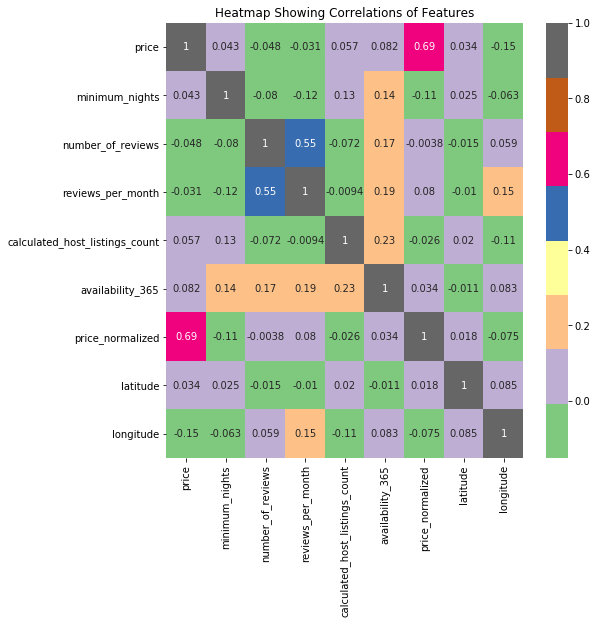

In [51]:
# Plot heatmap 

df_corr = df[['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 
           'calculated_host_listings_count', 'availability_365', 'price_normalized',
           'latitude', 'longitude']]

plt.figure(figsize=(8,8))  
sns.heatmap(df_corr.corr(), cmap='Accent', annot=True)
plt.title('Heatmap Showing Correlations of Features')

## Visualize The AirBnb Listings

In [52]:
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [53]:
# Read in a shape file of NYC

nb = gpd.read_file('Neighborhood Tabulation Areas/geo_export_40619f58-fd96-4939-9f41-bdb9fd1f7f99.shp')

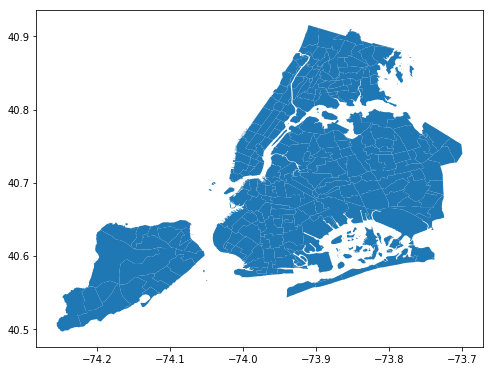

In [54]:
# Plot what the shape value looks like 

fig, ax = plt.subplots(figsize=(8,8))
nb.plot(ax = ax)

In [210]:
# Create a GeoPandas DataFrame which contains Points 

# First create geographic Points using the lat/long values from the DataFrame
geometry = [Point(xy) for xy in zip( df['longitude'], df['latitude'])]

crs = {'init': 'epsg:4326'} # specify our Coordinate Reference System (crs)

geo_df = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
geo_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,price_normalized,geometry
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,10/19/18,0.21,6,365,149.0,POINT (-73.97237 40.64749)
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,5/21/19,0.38,2,355,225.0,POINT (-73.98377 40.75362)
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365,50.0,POINT (-73.94190 40.80902)
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,7/5/19,4.64,1,194,89.0,POINT (-73.95976 40.68514)
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,11/19/18,0.10,1,0,8.0,POINT (-73.94399 40.79851)


Text(0.5,1,'NYC AirBnb Listings')

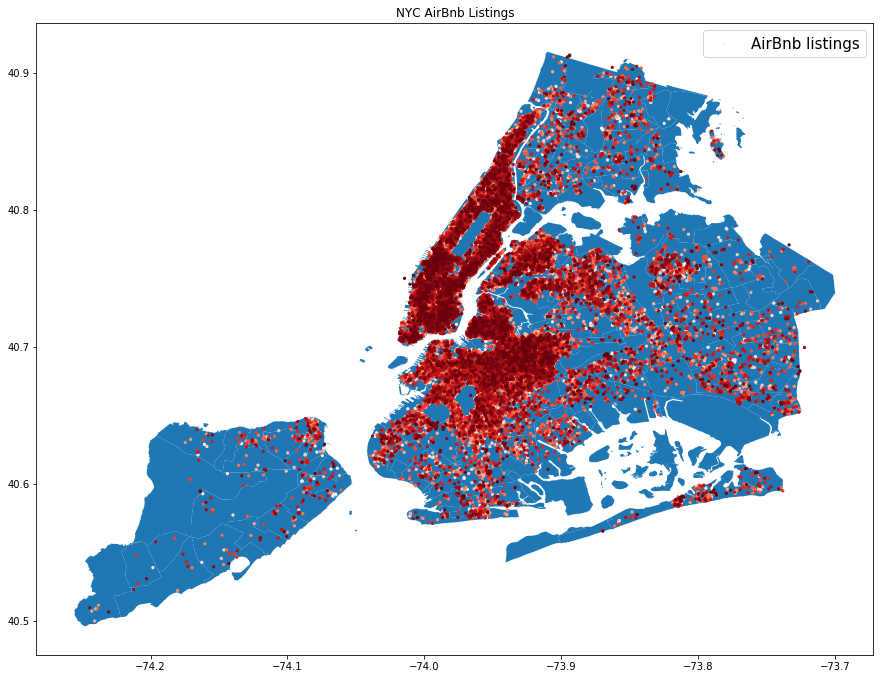

In [214]:
# Plot the AirBnb Listings over our Shapefile 

fig,ax = plt.subplots(figsize=(15,15))
nb.plot(ax = ax, alpha=1) #, color='grey')
geo_df.plot(ax=ax, markersize=5, cmap='Reds', #edgecolor='k',
            marker='o', label='AirBnb listings')
plt.legend(prop={'size':15})
plt.title('NYC AirBnb Listings')
#plt.savefig('NYC_listings')


## Implement K-Means Algorithm to find novelties in the data

#### Notes about K-Means: 
1. Pros \
    a. Simple, easy to implement \
    b. Efficient \
    c. Often terminates at local optimum \
    d. Works well in practice     
    e. If we start frommg good initial point we may converge faster 
2. Cons \
    a. Applicable to only objects in continuous n-dim space \
    b. Does not work with categorical data (unless transformed) \
    c. Need to specify K in advance \
    d. Sensitive to noisy data and outliers \
    e. Good when clusters are Gaussian \
    f. Each time we run algorithm, we may get different answer since we start at random k \
    g. You might have an empty cluster due to bad starting point 
   


#### Algorithm: 
1. Initialize cluster centroids \
	a. Pick k points at random and set as centroids represented each cluster 
2. Repeat while cluster assignments don't change \
	a. Assign each point to nearest centroid
    b. Given new assignments, compute new cluster centroids as mean of all possible points in cluster \
1) What neighborhoods are the most expensive? \
2) What room_types are most desirable? \
3) Cluster listing based on room_type / price / num_reviews (popularity) 


#### Intuition on Choosing K: 
1) # Unique Neighborhoods Groups: 5 \
            ['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx'] \
2) # Unique Room_Types: 3 \
            ['Private room', 'Entire home/apt', 'Shared room'] 
            

In [90]:
# Look at some basic stats in our data

df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,price_normalized
count,4.888400e+04,4.888400e+04,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000,38833.000000,48884.000000,48884.000000,48884.000000
mean,1.901679e+07,6.762203e+07,40.728953,-73.952176,152.755053,7.029887,23.271991,1.373128,7.144628,112.779498,70.190038
std,1.098432e+07,7.861666e+07,0.054532,0.046159,240.170260,20.512224,44.551331,1.680391,32.956185,131.627271,157.634605
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,10.000000,1.000000,0.000000,0.010000,1.000000,0.000000,0.040000
25%,9.470548e+06,7.817310e+06,40.690100,-73.983080,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000,20.000000
50%,1.967574e+07,3.079257e+07,40.723080,-73.955685,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000,44.500000
75%,2.915297e+07,1.074344e+08,40.763120,-73.936290,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000,81.666667
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000,8000.000000


We can see that there are extreme min/max price values above

## Prepare data for K-Means Algorithm


The generate_data() function will remove outliers and return a slice of sample data from the Staten Island neighbourhood_group, with 2 fetaures: price_normalized and number_of_reviews. \
We are interested in seeing if there exists any correlations or natural groupings related to popularity of a listing 
(using number_of_reviews) and price (price_normalized)

In [1]:
from KMeansAlgorithm import generate_data

staten_df = generate_data('data/new-york-city-airbnb-open-data/AB_NYC_2019.csv')
print("Staten Island Neighbourhood Group - Sample Data")
staten_df.head()

Staten Island Neighbourhood Group - Sample Data


,price_normalized,number_of_reviews
702,125.000000,21
704,62.500000,8
1424,99.666667,59
2906,25.000000,19
4248,75.000000,1


## Import and Run K-Means Algorithm

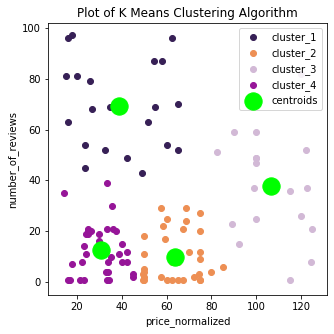

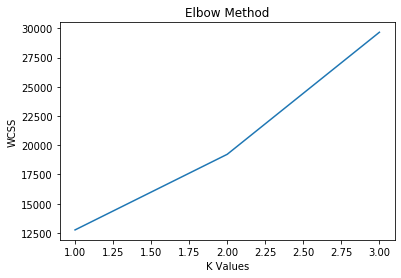

{1: array([[35.        , 69.        ],
       [51.66666667, 63.        ],
       [15.        , 81.        ],
       [26.        , 79.        ],
       [62.5       , 96.        ],
       [32.5       , 52.        ],
       [16.25      , 96.        ],
       [23.75      , 54.        ],
       [18.        , 97.        ],
       [23.75      , 45.        ],
       [26.66666667, 68.        ],
       [49.        , 43.        ],
       [42.5       , 49.        ],
       [54.5       , 87.        ],
       [58.        , 87.        ],
       [65.        , 70.        ],
       [16.25      , 63.        ],
       [20.        , 81.        ],
       [55.        , 69.        ],
       [60.        , 54.        ],
       [65.        , 52.        ]]), 2: array([[62.5       ,  8.        ],
       [75.        ,  1.        ],
       [58.33333333, 22.        ],
       [68.75      , 29.        ],
       [68.75      , 24.        ],
       [50.        ,  2.        ],
       [60.        , 25.        ],
       [72.

In [5]:
from KMeansAlgorithm import KMeansAlgorithm

kmeans = KMeansAlgorithm(staten_df, 4) # setting K=4
kmeans.fit_model(100) # 100 iterations
kmeans.plot_kmeans() 
results, centroids = kmeans.predict()
kmeans.plot_elbow()

print(results)
print()
print(centroids)
